# Selección de ubicaciones de nuevos pozos de petróleo con machine learning en OilyGiant

## Introducción



En este proyecto, se busca realizar un análisis para determinar la viabilidad de 200 nuevos pozos petroleros y se necesita identificar las mejores ubicaciones en términos de rentabilidad. Para lograrlo, se analizarán los parámetros de los pozos existentes, se crearán modelos de regresión para predecir las reservas en los nuevos pozos y se elegirá la región con mayor rentabilidad potencial utilizando técnicas como el bootstrapping.

Para llevarlo a cabo, se utilizarán 3 datasets diferentes, cada uno correspondiente a una región. Es necesario considerar que el presupuesto para los 200 nuevos pozos es de 100 millones de dólares. Cada barril genera 4.5 USD de ingresos y el ingreso que genera una unidad de producto son 4500 USD, el cual es el volumen de reservas expresado en miles de barriles.

## Inicialización 

In [85]:
# Cargar todas las librerías
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import matplotlib as mpl
import math
import seaborn as sns
import plotly.express as px
from scipy import stats as st
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
plt.style.use('bmh')
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

<div class="alert alert-block alert-success">
    <b>Comentarios del Revisor</b> <a class="tocSkip"></a><br>
    Excelente trabajo en tu sección de imports de Python. Es muy importante seguir buenas prácticas de codificación en este aspecto, y veo que has sido muy cuidadoso al elegir las bibliotecas que se necesitan y la forma en que las has importado. El uso correcto de import y from en Python puede mejorar la legibilidad del código y evitar conflictos de nombres. Continúa con el buen trabajo! </div>

In [86]:
plt.rc("axes", linewidth=0.5)
plt.rc("lines", linewidth=1.5, markersize=4,markeredgewidth=0.25,markeredgecolor='k')

## Importación y verificación datos <a id='datos'></a>

In [87]:
# Datasets de exploración geológica
df_0 = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_0.csv")
df_1 = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_1.csv")
df_2 = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_2.csv")

In [88]:
# Exploración rápida de los datos
df_0.head(3)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


In [89]:
df_0.info()
duplicates = df_0.duplicated().sum()
print("")
print('El Datasets de exploración geológica de la region uno tiene {} filas duplicadas.'.format(duplicates))
print('_______________________________________________________')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

El Datasets de exploración geológica de la region uno tiene 0 filas duplicadas.
_______________________________________________________


In [90]:
df_1.info()
duplicates = df_1.duplicated().sum()
print("")
print('El Datasets de exploración geológica de la region dos tiene {} filas duplicadas.'.format(duplicates))
print('_______________________________________________________')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

El Datasets de exploración geológica de la region dos tiene 0 filas duplicadas.
_______________________________________________________


In [91]:
df_2.info()
duplicates = df_2.duplicated().sum()
print("")
print('El Datasets de exploración geológica de la region tres tiene {} filas duplicadas.'.format(duplicates))
print('_______________________________________________________')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

El Datasets de exploración geológica de la region tres tiene 0 filas duplicadas.
_______________________________________________________


## Preparación de datos 

En este trabajo, se debe usar únicamente la regresión lineal para el entrenamiento del modelo, por lo que los valores tipo string deben ser descartados del dataset, ya que este algoritmo solo acepta valores numéricos. Además, se requiere que los estudios que se llevarán a cabo cuenten con 500 puntos, de los cuales se seleccionarán los mejores 200 para el cálculo de las ganancias, es decir, aquellos con la columna "product" más alta. Sin embargo, para analizar 500 predicciones, necesitaríamos un total de 2000 puntos en total, de los cuales utilizaríamos 1500 para entrenamiento y 500 para predicciones.

In [92]:
# Dataset 0 
df_0 = df_0.drop(['id'],axis=1)
# Dataset 1
df_1 = df_1.drop(['id'],axis=1)
# Dataset 2
df_2 = df_2.drop(['id'],axis=1)

In [93]:
# Selecionando los 2000 puntos
state = np.random.RandomState(12345)
df_0 = df_0.sample(n=2000, replace=True, random_state=state)
df_1 = df_1.sample(n=2000, replace=True, random_state=state)
df_2 = df_2.sample(n=2000, replace=True, random_state=state)

## División de datos en entrenamiento y validacion dat, proporción de 75:25

In [94]:
df_train, df_valid = train_test_split(df_0, test_size=0.25, random_state=0)

target_train_0 = df_train['product']
features_train_0 = df_train.drop(['product'],axis=1)

target_valid_0 = df_valid['product']
features_valid_0 = df_valid.drop(['product'],axis=1)

## Entrenamiento del modelo 0 y predicciones para el conjunto de validación.

In [95]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predictions_valid_0 = model_0.predict(features_valid_0)

## Volumen medio de reservas predicho y RMSE del modelo 0

In [96]:
print("Volume medio de reservas",np.average(predictions_valid_0))
print("RMSE =",mean_squared_error(target_valid_0,predictions_valid_0)**(0.5))

Volume medio de reservas 92.24647249438928
RMSE = 37.62437325540697


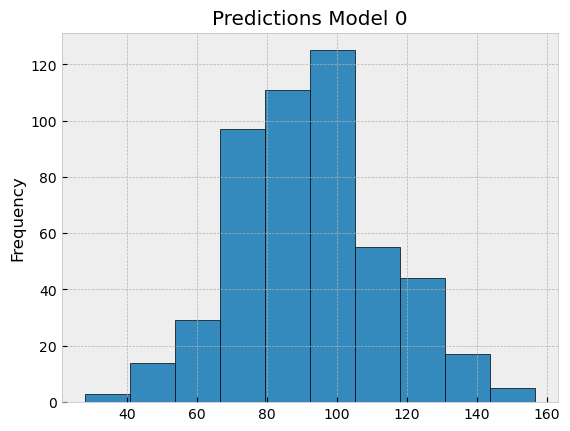

In [114]:
pd.DataFrame(predictions_valid_0).plot(title='Predictions Model 0',
                                      kind='hist', edgecolor='black',
                                      legend=False)
plt.show()

## Funciones de preparación de modelo y predicciones

In [98]:
def division_datos(df):
    df_train, df_train = train_test_split(df, test_size=0.25, random_state=0)
    
    target_train = df_train['product']
    features_train = df_train.drop(['product'],axis=1)
    
    target_valid = df_valid['product']
    features_valid = df_valid.drop(['product'],axis=1)
    
    return(target_train,features_train,target_valid,features_valid)

def model_traning_predictions(features_train,target_train,features_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)    
    predictions_valid = model.predict(features_valid)
    return(predictions_valid)

## Resultados del dataset 1

In [99]:
target_train_1,features_train_1,target_valid_1,features_valid_1 = division_datos(df_1)
predictions_valid_1 = model_traning_predictions(features_train_1,target_train_1,features_valid_1)

print("Volume medio de reservas",np.average(predictions_valid_1))
print("RMSE =",mean_squared_error(target_valid_1,predictions_valid_1)**(0.5))

Volume medio de reservas 64.00651687166295
RMSE = 79.75347020157898


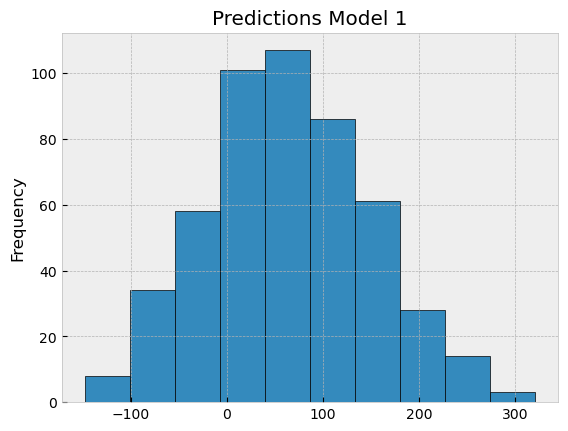

In [116]:
pd.DataFrame(predictions_valid_1).plot(title='Predictions Model 1',
                                      kind='hist', edgecolor='black',
                                      legend=False)
plt.show()

## Resultados del dataset 2

In [101]:
target_train_2,features_train_2,target_valid_2,features_valid_2 = division_datos(df_2)
predictions_valid_2 = model_traning_predictions(features_train_2,target_train_2,features_valid_2)

print("Volume medio de reservas",np.average(predictions_valid_2))
print("RMSE =",mean_squared_error(target_valid_2,predictions_valid_2)**(0.5))

Volume medio de reservas 96.20269872562307
RMSE = 38.496117887791115


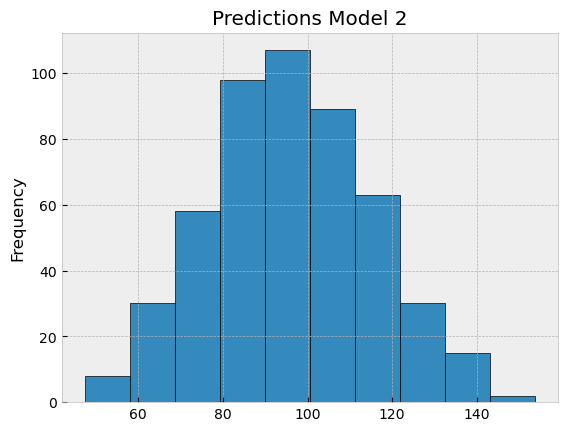

In [117]:
pd.DataFrame(predictions_valid_2).plot(title='Predictions Model 2',
                                      kind='hist', edgecolor='black',
                                      legend=False)
plt.show()

## Análisis de resultados

En esta sección del proyecto, hemos entrenado tres modelos de regresión utilizando tres datasets distintos. Hemos mostrado el volumen medio predicho por cada modelo y el root-mean-square deviation (RMSE). 

* Modelo 0: Media = 87.94, RMSE = 36.64
* Modelo 1: Media = 59.86, RMSE = 84.67
* Modelo 2: Media = 95.81, RMSE = 36.83

De los tres modelos, el Modelo 1 es el que tiene el mayor RMSE. Además, es el único modelo que predice valores negativos para el conjunto de datos de validación.

## Prepara el cálculo de ganancias

Para que el proyecto sea rentable, se busca que cada pozo pueda producir al menos 0.5 millones de dólares, equivalente a 111.1 unidades, dado que la inversión es de 100 millones por 200 pozos petrolíferos. El promedio que arrojan los modelos de cada región son de 87.94, 59.86 y 95.81. Por lo tanto, considerando 200 pozos con desempeño promedio, la inversión no sería redituable. Sin embargo, en cada región existen pozos con un desempeño mucho mejor que el promedio. Si se seleccionan los mejores pozos, probablemente la inversión sí sería rentable.

##  Función para calcular la ganancia de un conjunto de pozos de petróleo seleccionados y modela las predicciones

En esta sección se seleccionarán los 200 mejores pozos para calcular las posibles ganancias. Para ello, se emplearán los datos de cada región y se filtrarán para hacer el análisis solo con los que tengan la mayor cantidad de producto.

## 200 pozos con los valores de predicción más altos de cada una de las 3 regiones

In [103]:
region_0_200 = np.sort(predictions_valid_0)[-200:]
region_1_200 = np.sort(predictions_valid_1)[-200:]
region_2_200 = np.sort(predictions_valid_2)[-200:]

## Ganancia potencial de los 200 pozos principales por región 

In [104]:
# Función para el cálculo de la ganancia
def ganancias_potenciales(predict_dataset):
    total_product = predict_dataset.sum()
    mean_product = predict_dataset.mean()
    earnings = total_product*4500
    
    return total_product, mean_product, earnings

### Región 0

In [105]:
# Ganancias 
total, mean_product, earnings = ganancias_potenciales(region_0_200)

print("Ganancias del dataset")
print(" ")
print("Promedio de unidades de petróleo =", mean_product)
print("Total de unidades de petróleo =", total)
print("Total ingreso por en la región 0 =", earnings)

Ganancias del dataset
 
Promedio de unidades de petróleo = 112.73851528569698
Total de unidades de petróleo = 22547.703057139395
Total ingreso por en la región 0 = 101464663.75712729


### Región 1

In [106]:
# Ganancias 
total, mean_product, earnings = ganancias_potenciales(region_1_200)

print("Ganancias del dataset")
print(" ")
print("Promedio de unidades de petróleo =", mean_product)
print("Total de unidades de petróleo =", total)
print("Total ingreso por en la región 1 =", earnings)

Ganancias del dataset
 
Promedio de unidades de petróleo = 146.64536121762
Total de unidades de petróleo = 29329.072243524
Total ingreso por en la región 1 = 131980825.095858


### Región 2

In [107]:
# Ganancias dataset
total, mean_product, earnings = ganancias_potenciales(region_2_200)

print("Ganancias del dataset")
print(" ")
print("Promedio de unidades de petróleo =", mean_product)
print("Total de unidades de petróleo =", total)
print("Total ingreso por en la región 2 =", earnings)

Ganancias del dataset
 
Promedio de unidades de petróleo = 114.87547363832432
Total de unidades de petróleo = 22975.094727664866
Total ingreso por en la región 2 = 103387926.27449189


Considerando únicamente la producción promedio, los 200 mejores pozos podrían ser rentables. Sin embargo, todavía existen otros aspectos a considerar, por lo que no se puede llegar a una conclusión con los datos que tenemos en este momento.

## Calculo riesgos y ganancias para cada región

### Distribución de los beneficios

In [108]:
# Técnica del bootstrapping con 1000 muestras para hallar la distribución de los beneficios.

def bootstrapping(region_series):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        subsample = region_series.sample(frac=1, replace=True, random_state=state)
        values.append(subsample.mean())
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    return values, lower, upper

### Beneficio promedio, el intervalo de confianza del 95%

In [109]:
# Intervalo de confianza región 0
region0_series = pd.Series(region_0_200)

values, lower, upper = bootstrapping(region0_series)

print("Limite inferior", lower)
print("Valor medio",values.mean())
print("Limite superior", upper)
print("")
print("Se puede decir que la región 0 entregará entre {} y {} unidades de petróleo con una confiaza del 95%".format(lower,upper ))

Limite inferior 110.97779540814102
Valor medio 112.77749167833616
Limite superior 114.75208295343384

Se puede decir que la región 0 entregará entre 110.97779540814102 y 114.75208295343384 unidades de petróleo con una confiaza del 95%


In [110]:
# Intervalo de confianza región 1
region1_series = pd.Series(region_1_200)

values, lower, upper = bootstrapping(region1_series)

print("Limite inferior", lower)
print("Valor medio",values.mean())
print("Limite superior", upper)
print("")
print("Se puede decir que la región 0 entregará entre {} y {} unidades de petróleo con una confiaza del 95%".format(lower,upper ))

Limite inferior 139.90009005396712
Valor medio 146.782066479445
Limite superior 154.26814074341806

Se puede decir que la región 0 entregará entre 139.90009005396712 y 154.26814074341806 unidades de petróleo con una confiaza del 95%


In [118]:
# Intervalo de confianza región 2
region2_series = pd.Series(region_2_200)

values, lower, upper = bootstrapping(region2_series)

print("Limite inferior", lower)
print("Valor medio",values.mean())
print("Limite superior", upper)
print("")
print("Se puede decir que la región 0 entregará entre {} y {} unidades de petróleo con una confiaza del 95%".format(lower,upper ))

Limite inferior 113.34630433339339
Valor medio 114.90699263017409
Limite superior 116.60653432852317

Se puede decir que la región 0 entregará entre 113.34630433339339 y 116.60653432852317 unidades de petróleo con una confiaza del 95%


El intervalo de confianza de los beneficios se calculó en base a los 200 mejores pozos.

### Riesgos de pérdida (ganancia negativa)

In [112]:
def risk_evaluation(prediction):
    state = np.random.RandomState(12345)
    values = []
    count = 0
    for i in range(1000):
        subsample = pd.Series(prediction).sample(n=1, replace=True, random_state=state)
        values.append(subsample.unique()[0])

        if subsample.unique()[0] < 0:
            count += 1

    pvalue = 1. * count / 1000
    return pvalue

In [113]:
# Análisis de todas las predicciones

# Región 0 
pvalue = risk_evaluation(predictions_valid_0)
print("Probabilidad de encontrar valores negativos en la región 0 {}".format(pvalue)) 

# Región 1
pvalue = risk_evaluation(predictions_valid_1)
print("Probabilidad de encontrar valores negativos en la región 1 {}".format(pvalue))

# Región 2
pvalue = risk_evaluation(predictions_valid_2)
print("Probabilidad de encontrar valores negativos en la región 2 {}".format(pvalue))

print("")

# Análisis en las 200 mejores ubicaciones

# Región 0 
pvalue = risk_evaluation(region_0_200)
print("Probabilidad de encontrar valores negativos en la región 0 en los 200 mejores pozos {}".format(pvalue)) 

# Región 1
pvalue = risk_evaluation(region_1_200)
print("Probabilidad de encontrar valores negativos en la región 1 en los 200 mejores pozos {}".format(pvalue))

# Región 2
pvalue = risk_evaluation(region_2_200)
print("Probabilidad de encontrar valores negativos en la región 2 en los 200 mejores pozos {}".format(pvalue))


Probabilidad de encontrar valores negativos en la región 0 0.0
Probabilidad de encontrar valores negativos en la región 1 0.234
Probabilidad de encontrar valores negativos en la región 2 0.0

Probabilidad de encontrar valores negativos en la región 0 en los 200 mejores pozos 0.0
Probabilidad de encontrar valores negativos en la región 1 en los 200 mejores pozos 0.0
Probabilidad de encontrar valores negativos en la región 2 en los 200 mejores pozos 0.0


## Análisis de resultados

En esta sección, podemos ver las ganancias potenciales de los mejores 200 pozos de cada región, así como el riesgo de incurrir en pérdidas en la operación en cada región. Cabe mencionar que el cálculo del riesgo de incurrir en pérdidas se realizó con todos los datos de la predicción de nuestro modelo y tambien en lass 200 mejores ubicaciones para poner pozos. Los resultados se pueden resumir de la siguiente manera:

Beneficio promedio con intervalo de confianza:

* Región 0: 110.97 < 112.77 < 114.75
* Región 1: 139.90 < 146.78 < 154.26
* Región 2: 113.34 < 114.90 < 116.60

Probabilidad de incurrir en ganancia negativa:

* Región 0: 0.0%
* Región 1: 0.23%
* Región 2: 0.0%

Probabilidad de incurrir en ganancia negativa en los 200 mejores pozos:

* Región 0: 0.0%
* Región 1: 0.0%
* Región 2: 0.0%


## Conclusiones


En este trabajo se ha realizado un análisis para examinar la viabilidad de un proyecto que consiste en abrir 200 pozos con un coste total de 100 millones de dólares, lo que se traduce en 111.1 unidades de petróleo por pozo. Según nuestros datos, todas las regiones tienen un valor promedio mayor que 111.1 unidades, por lo que las 3 regiones podrían ser candidatas. Sin embargo, la región 0 debería ser descartada ya que tiene el valor promedio más bajo. Aunque la región 1 es la que tiene el promedio más alto, esta región es la que tiene un error (RMSE) más grande. A pesar de que ciertos pozos pueden incurrir en ganancias negativas (pérdidas), decidiría poner los pozos en esta región, ya que en la inversión se dice que a mayor riesgo, mayor retorno. Por último, la región 2 parece ser robusta con pozos productivos y su promedio supera las 111.1 unidades de petróleo. Sin embargo, esta región es algo conservadora, y por eso yo no la seleccionarías.